In [2]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# packet_count = None

# def visualize_csi(file_path):
#     # Load the CSV file
#     df = pd.read_csv(file_path)

#     # Extract CSI_Amplitude and CSI_Phase columns
#     try:
#         csi_amplitude = df['CSI_Amplitude'].apply(eval)  # Convert string list to actual list
#         csi_phase = df['CSI_Phase'].apply(eval)  # Convert string list to actual list
#     except KeyError:
#         print("Error: 'CSI_Amplitude' or 'CSI_Phase' column not found in the file.")
#         return

#     # Plot CSI Amplitude
#     plt.figure(figsize=(12, 6))
#     plt.title("CSI Amplitude Visualization")
#     for idx, amp in enumerate(csi_amplitude[:5]):  # Plot first 5 entries
#         plt.plot(range(len(amp)), amp, label=f'Packet {idx + 1}')
#     plt.xlabel("Subcarrier Index")
#     plt.ylabel("Amplitude")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Plot CSI Phase
#     plt.figure(figsize=(12, 6))
#     plt.title("CSI Phase Visualization")
#     for idx, phase in enumerate(csi_phase[:5]):  # Plot first 5 entries
#         plt.plot(range(len(phase)), phase, label=f'Packet {idx + 1}')
#     plt.xlabel("Subcarrier Index")
#     plt.ylabel("Phase (Radians)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Heatmap for CSI Amplitude (optional)
#     csi_amplitude_matrix = np.array(csi_amplitude.tolist())[:50]  # Convert first 50 entries into matrix
#     plt.figure(figsize=(10, 8))
#     plt.title("CSI Amplitude Heatmap")
#     plt.imshow(csi_amplitude_matrix, aspect='auto', cmap='viridis', interpolation='none')
#     plt.colorbar(label='Amplitude')
#     plt.xlabel("Subcarrier Index")
#     plt.ylabel("Packet Index")
#     plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def filter_null_subcarriers(amplitudes, phases):
    '''
    Filter out null subcarriers (amplitude == 0.0).
    param amplitudes: List of amplitude values.
    param phases: List of phase values.
    return: Filtered lists of amplitudes and phases.
    '''
    filtered_amplitudes = []
    filtered_phases = []
    
    for amp, phase in zip(amplitudes, phases):
        if amp != 0.0:
            filtered_amplitudes.append(amp)
            filtered_phases.append(phase)
    
    return filtered_amplitudes, filtered_phases

def visualize_csi_advanced(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Extract CSI_Amplitude and CSI_Phase columns
    try:
        csi_amplitude = df['CSI_Amplitude'].apply(eval)  # Convert string list to actual list
        csi_phase = df['CSI_Phase'].apply(eval)  # Convert string list to actual list
    except KeyError:
        print("Error: 'CSI_Amplitude' or 'CSI_Phase' column not found in the file.")
        return

    filtered_amplitudes, filtered_phases = filter_null_subcarriers(csi_amplitude, csi_phase)

    # 3D Surface Plot - Fixed for Uniform Shape
    plt.figure(figsize=(20, 20))
    ax = plt.axes(projection='3d')

    # Truncate or pad CSI Amplitude data to uniform length
    amplitude_data = [amp[:len(filtered_amplitudes[0])] for amp in filtered_amplitudes[:50]]  # Ensure uniform shape
    Z = np.array(filtered_amplitudes)

    x = np.arange(Z.shape[1])  # Subcarrier Index (columns)
    y = np.arange(Z.shape[0])  # Packet Index (rows)
    X, Y = np.meshgrid(x, y)

    ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.title("3D Surface Plot: CSI Amplitude")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Packet Index")
    ax.set_zlabel("Amplitude")
    plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def filter_reflections(amplitudes, phases, amplitude_threshold=10):
    """
    Filters out the direct path data based on amplitude threshold.
    """
    filtered_amplitudes = []
    filtered_phases = []
    
    for amp, phase in zip(amplitudes, phases):
        amp = np.array(amp)
        phase = np.array(phase)
        
        # Filter values below the amplitude threshold
        mask = amp < amplitude_threshold
        filtered_amplitudes.append(amp[mask])
        filtered_phases.append(phase[mask])
    
    return filtered_amplitudes, filtered_phases

def map_reflections_to_3d(filtered_amplitudes, filtered_phases):
    """
    Maps reflected CSI data to approximate 3D coordinates.
    """
    reflected_positions = []
    for amp, phase in zip(filtered_amplitudes, filtered_phases):
        # Use amplitude to approximate distance (scaled)
        distances = amp / np.max(amp) * 10  # Normalize and scale distances
        angles = np.linspace(0, 2 * np.pi, len(amp))  # Spread reflections in a circular pattern
        
        # Map to 3D coordinates
        x = distances * np.cos(angles)
        y = distances * np.sin(angles)
        z = phase  # Use phase as an approximation for height variation
        
        for i in range(len(x)):
            reflected_positions.append((x[i], y[i], z[i]))
    
    return np.array(reflected_positions)

def visualize_3d_with_ap_device(file_path):
    # Load CSI data
    df = pd.read_csv(file_path)
    try:
        csi_amplitude = df['CSI_Amplitude'].apply(eval)
        csi_phase = df['CSI_Phase'].apply(eval)
    except KeyError:
        print("Error: 'CSI_Amplitude' or 'CSI_Phase' column not found.")
        return
    
    # Filter reflected data
    amplitude_threshold = 10
    filtered_amplitudes, filtered_phases = filter_null_subcarriers(csi_amplitude, csi_phase)
    filtered_amplitudes, filtered_phases = filter_reflections(filtered_amplitudes, filtered_phases, amplitude_threshold)
    

    print(csi_amplitude.shape)
    print(len(filtered_amplitudes))
    # Map reflections to 3D space
    reflected_positions = map_reflections_to_3d(filtered_amplitudes, filtered_phases)
    
    # Define fixed AP and device positions
    ap_position = (0, 0, 0)
    device_position = (5, 0, 0)  # Adjust based on estimated location
    
    # Visualization
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot AP and device positions
    ax.scatter(*ap_position, c='red', s=100, label="Access Point (AP)")
    ax.scatter(*device_position, c='blue', s=100, label="Receiving Device")
    
    # Plot reflected CSI points
    ax.scatter(reflected_positions[:, 0], reflected_positions[:, 1], reflected_positions[:, 2], 
               c='green', s=20, label="Reflected CSI Data")
    
    # Axes labels and legend
    ax.set_title("3D Visualization of AP, Device, and Reflected CSI Data")
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_zlabel("Z (phase height approximation)")
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def clean_and_filter_data(amplitudes, phases, amp_lower_threshold, amp_upper_threshold, 
                          phase_lower_threshold, phase_upper_threshold):
    cleaned_amplitudes = []
    cleaned_phases = []
    subcarriers = range(len(amplitudes))

    for i, amp, phase in zip(subcarriers, amplitudes, phases):
        # Remove null subcarriers
        if amp == 0: continue
        
        # # Retain outliers based on amplitude
        # if (amp < amp_lower_threshold[i]) or (amp > amp_upper_threshold[i]):
        #     cleaned_amplitudes.append(amp)
        #     cleaned_phases.append(phase)

        # # Retain outliers based on phase
        # if (phase < phase_lower_threshold[i]) or (phase > phase_upper_threshold[i]):
        #     cleaned_amplitudes.append(amp)
        #     cleaned_phases.append(phase)
        
        # Retain outliers based on amplitude and phase
        if ((amp < amp_lower_threshold[i]) or (amp > amp_upper_threshold[i]) and (phase < phase_lower_threshold[i]) or (phase > phase_upper_threshold[i])):
            cleaned_amplitudes.append(amp)
            cleaned_phases.append(phase)
        else:
            cleaned_amplitudes.append(np.nan)
            cleaned_phases.append(np.nan)

    return cleaned_amplitudes, cleaned_phases

def apply_wavelet_transform(csi_amplitude, csi_phase):
    transformed_amplitudes, transformed_phases = [], []

    for i in range(len(csi_amplitude)):
        csi_data = [a * np.exp(1j * p) for a, p in zip(csi_amplitude[i], csi_phase[i])]
        csi_data = pywt.swt(csi_data, 'db1', level=1)
        csi_data = pywt.iswt(csi_data, 'db1')

        # Separate amplitude and phase
        transformed_amplitudes.append(np.abs(csi_data))
        transformed_phases.append(np.angle(csi_data))
    
    return transformed_amplitudes, transformed_phases

def get_subcarrier_threshold(data_transposed, threshold):
    lower_threshold, upper_threshold = [], []

    for column in data_transposed:
        mean = np.mean(column)
        std_dev = np.std(column)

        lower_threshold.append(mean - threshold * std_dev)
        upper_threshold.append(mean + threshold * std_dev)

    return lower_threshold, upper_threshold

def visualize_reflections(file_path):
    df = pd.read_csv(file_path)

    try:
        csi_amplitude = df['CSI_Amplitude'].apply(eval)  # Convert string list to actual list
        csi_phase = df['CSI_Phase'].apply(eval)  # Convert string list to actual list
    except KeyError:
        print("Error: 'CSI_Amplitude' or 'CSI_Phase' column not found in the file.")
        return

    amp_transposed = list(map(list, zip(*csi_amplitude)))
    phase_transposed = list(map(list, zip(*csi_phase)))

    amp_lower_threshold, amp_upper_threshold = get_subcarrier_threshold(amp_transposed, threshold)
    phase_lower_threshold, phase_upper_threshold = get_subcarrier_threshold(phase_transposed, threshold)

    # csi_amplitude, csi_phase = apply_wavelet_transform(csi_amplitude, csi_phase)
    
    plt.figure(figsize=(8, 10))
    ax = plt.axes(projection='3d')

    for amp, phase in zip(csi_amplitude, csi_phase):
        amp = np.array(amp)
        phase = np.array(phase)

        cleaned_amplitudes, cleaned_phases = clean_and_filter_data(
            amp[5:], phase[5:], 
            amp_lower_threshold[5:], amp_upper_threshold[5:], 
            phase_lower_threshold[5:], phase_upper_threshold[5:]
        )

        x = np.arange(len(cleaned_amplitudes))
        y = cleaned_phases
        z = cleaned_amplitudes
        ax.scatter(x, y, z, c=z, cmap='coolwarm', marker='o')

    plt.title("3D Scatter Plot: Reflected CSI Data")
    ax.set_xlabel("Data Point Index")
    ax.set_ylabel("Phase (radians)")
    ax.set_zlabel("Amplitude")
    plt.show()

# threshold = 1.25
# file_path = "near.csv"
# visualize_reflections(file_path)

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

packet_count = None
window_size = None

def compute_csi_amplitude_phase(raw_csi):
    amplitudes = []
    phases = []
    
    # Ensure the data length is even (pairs of I and Q)
    if len(raw_csi) % 2 != 0:
        raise ValueError('CSI data length must be even (pairs of I and Q values).')
    
    for i in range(0, len(raw_csi), 2):
        I = raw_csi[i]
        Q = raw_csi[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    return amplitudes, phases


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def visualize_csi_updated(file_path):
    csi_data = pd.read_csv(file_path)
    # [[12:64] [66:118] [132:246] [254:368] [374:488] [496:610]]
    csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[12:64] + eval(x)[66:118] + eval(x)[132:246] + eval(x)[254:368] + eval(x)[374:488] + eval(x)[496:610])
    csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))
    print(csi_data['Movement'].values[:1])

    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: np.unwrap(x))

    # Apply moving average to smooth the data
    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: moving_average(x, window_size))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: moving_average(x, window_size))
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Plot CSI Amplitude
    axs[0].set_title("CSI Amplitude Visualization")
    for idx, amp in enumerate(csi_data['Amplitudes'][:packet_count]):
        axs[0].plot(range(len(amp)), amp)
    axs[0].set_xlabel("Subcarrier Index")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # Plot CSI Phase
    axs[1].set_title("CSI Phase Visualization")
    for idx, phase in enumerate(csi_data['Phases'][:packet_count]):
        axs[1].plot(range(len(phase)), phase)
    axs[1].set_xlabel("Subcarrier Index")
    axs[1].set_ylabel("Phase (Radians)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [60]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

packet_count = None
window_size = None

def compute_csi_amplitude_phase(raw_csi):
    amplitudes = []
    phases = []
    
    # Ensure the data length is even (pairs of I and Q)
    if len(raw_csi) % 2 != 0:
        raise ValueError('CSI data length must be even (pairs of I and Q values).')
    
    for i in range(0, len(raw_csi), 2):
        I = raw_csi[i]
        Q = raw_csi[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    return amplitudes, phases

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def visualize_amplitude(file_path):
    csi_data = pd.read_csv(file_path)
    # [[12:64] [66:118] [132:246] [254:368] [374:488] [496:610]]
    # csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[12:64] + eval(x)[66:118] + eval(x)[132:246] + eval(x)[254:368] + eval(x)[374:488] + eval(x)[496:610])
    csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[132:246])
    csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))
    print(csi_data['Movement'].values[:1])

    # Apply moving average to smooth the data
    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: moving_average(x, window_size))
    
    plt.figure(figsize=(8, 4))
    plt.title("CSI Amplitude Visualization")
    for idx, amp in enumerate(csi_data['Amplitudes'][:packet_count]):
        plt.plot(range(len(amp)), amp)
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

def visualize_phase(file_path):
    csi_data = pd.read_csv(file_path)
    # [[12:64] [66:118] [132:246] [254:368] [374:488] [496:610]]
    # csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[12:64] + eval(x)[66:118] + eval(x)[132:246] + eval(x)[254:368] + eval(x)[374:488] + eval(x)[496:610])
    csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[132:246])
    csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))
    print(csi_data['Movement'].values[:1])

    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: np.unwrap(x))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: moving_average(x, window_size))

    plt.figure(figsize=(8, 4))
    plt.title("CSI Phase Visualization")
    for idx, phase in enumerate(csi_data['Phases'][:packet_count]):
        plt.plot(range(len(phase)), phase)
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Phase")
    plt.grid(True)
    plt.show()

    plt.tight_layout()
    plt.show()

[0]


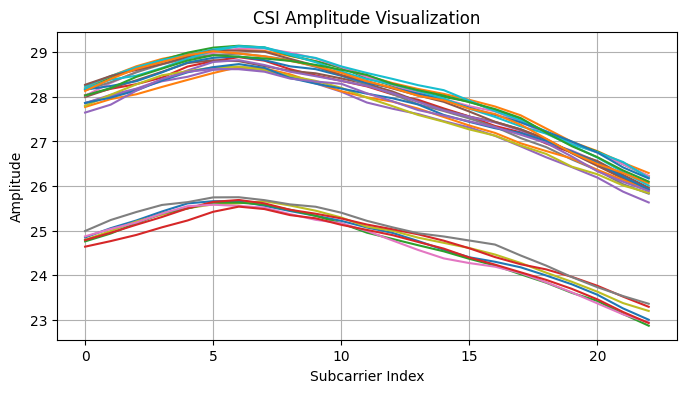

In [61]:
# File path to the CSV file
packet_count = 25
window_size = 35
file_path = '../dataset/s2_orig/CSI_DATA_090.csv'
visualize_amplitude(file_path)

[1]


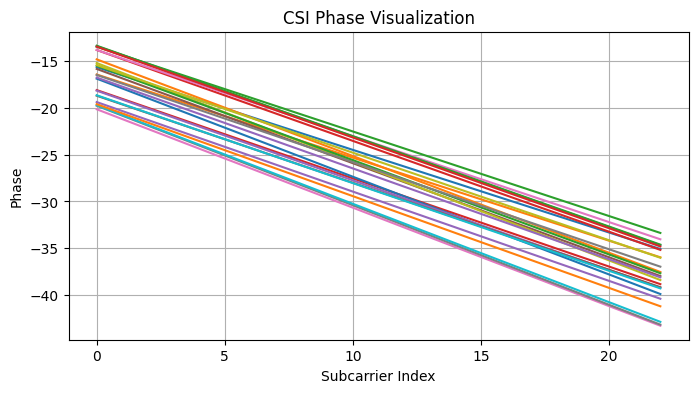

<Figure size 640x480 with 0 Axes>

In [62]:
# File path to the CSV file
packet_count = 25
window_size = 35
file_path = '../dataset/s2_orig/CSI_DATA_110.csv'
visualize_phase(file_path)

[1]


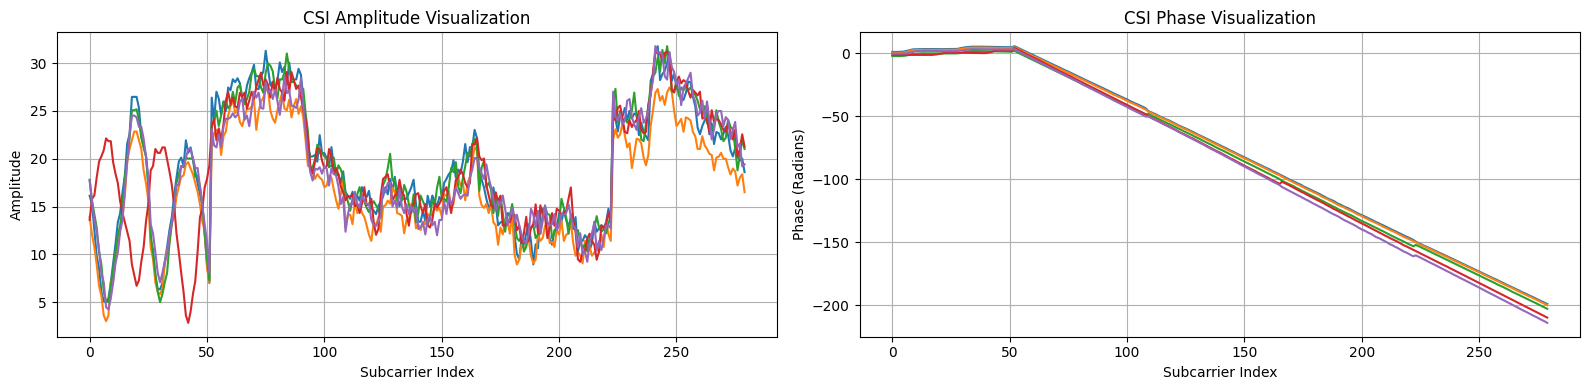

[0]


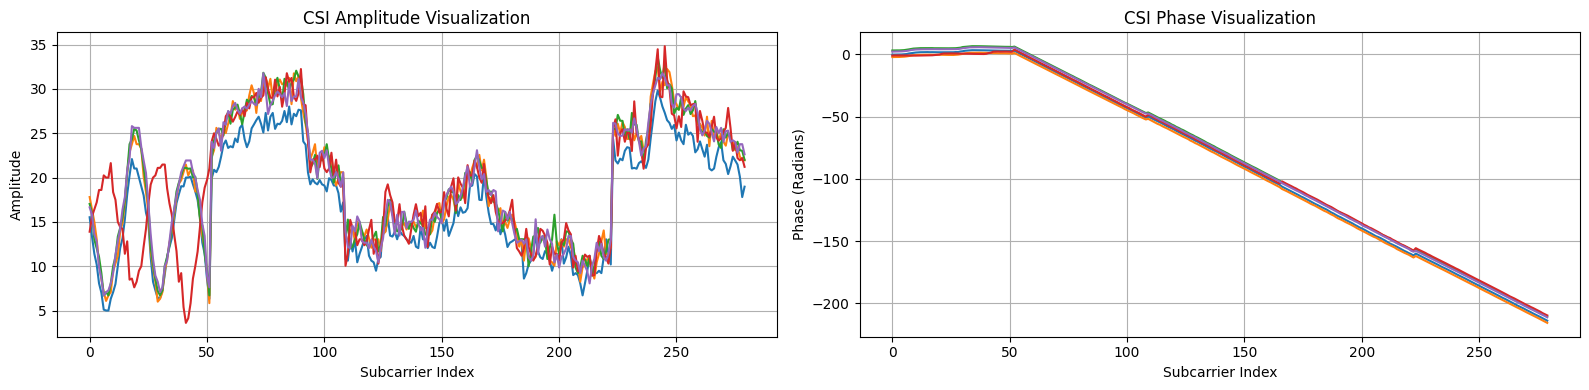

In [5]:
# File path to the CSV file
packet_count = 5
window_size = 1
file_path = '../dataset/s2_orig/CSI_DATA_110.csv'
visualize_csi_updated(file_path)
file_path = '../dataset/s2_orig/CSI_DATA_090.csv'
visualize_csi_updated(file_path)
# visualize_3d_with_ap_device(file_path)
# visualize_csi_advanced(file_path)

[1]


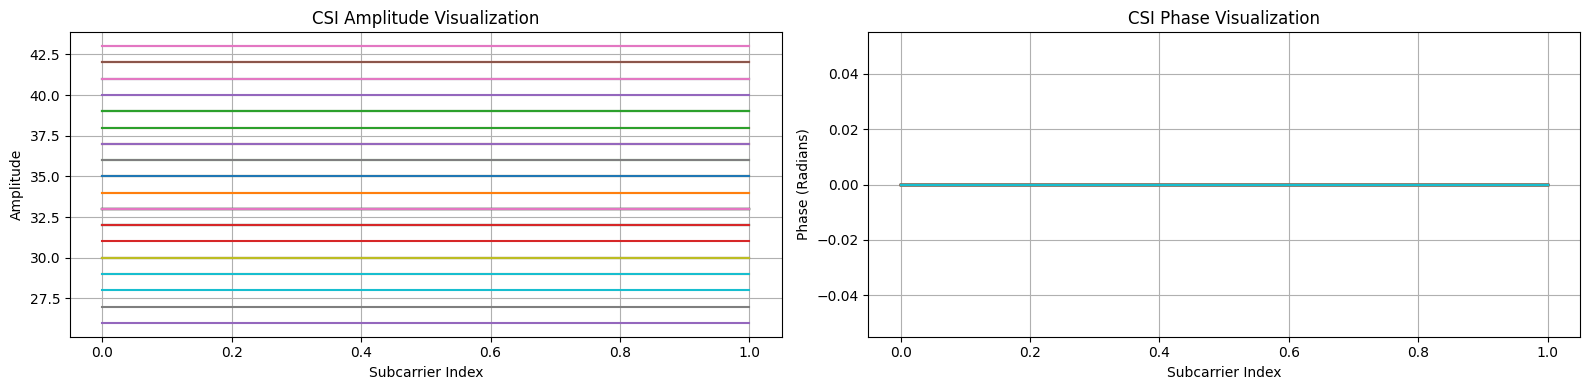

[0]


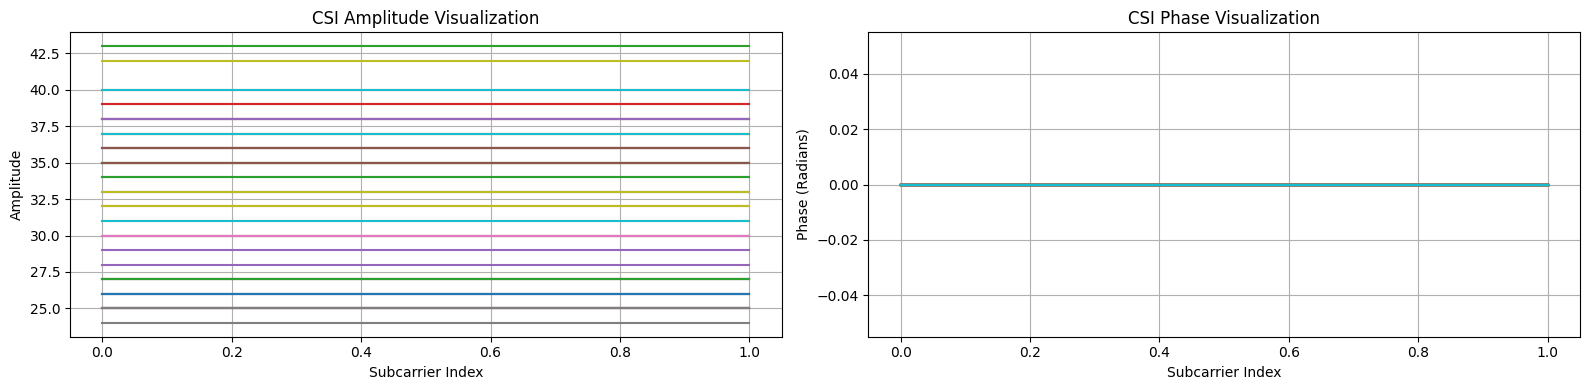

In [22]:
# File path to the CSV file
packet_count = 50
file_path = '../dataset/s2_orig/CSI_DATA_016.csv'
visualize_csi_updated(file_path)
file_path = '../dataset/s2_orig/CSI_DATA_025.csv'
visualize_csi_updated(file_path)
# visualize_3d_with_ap_device(file_path)
# visualize_csi_advanced(file_path)

[1]


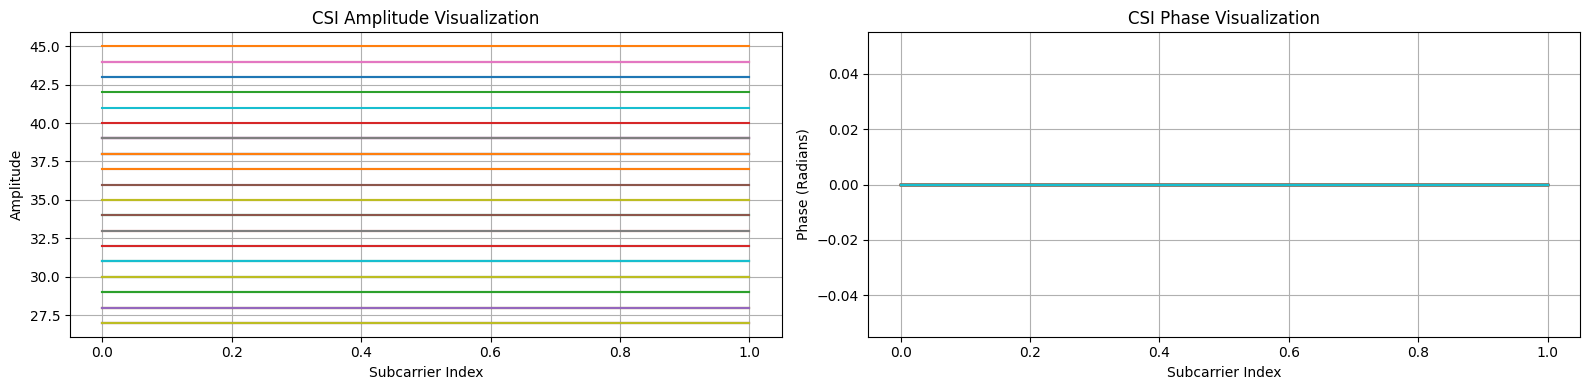

[0]


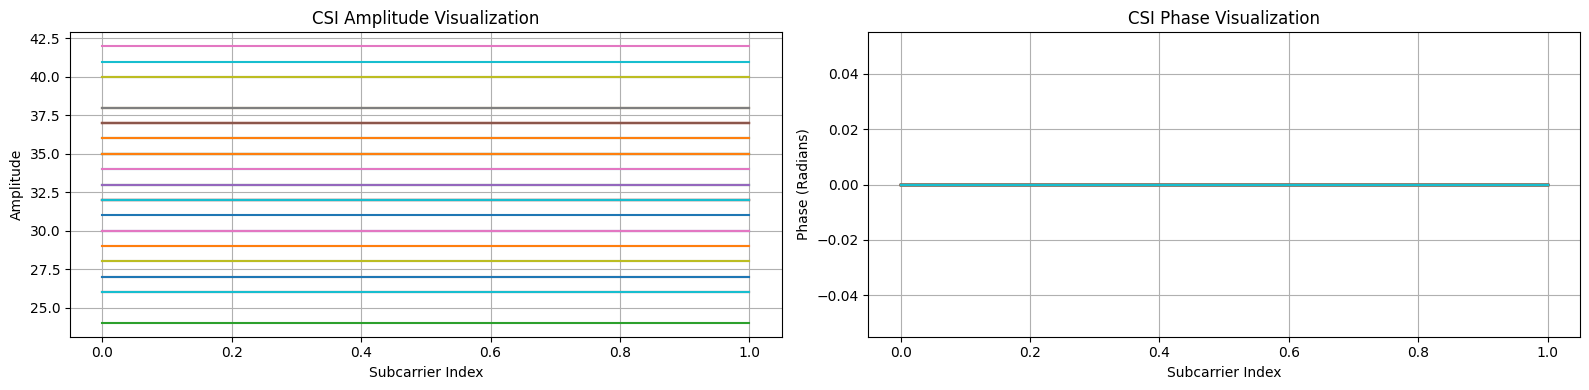

In [23]:
# File path to the CSV file
packet_count = 50
file_path = '../dataset/s2_orig/CSI_DATA_017.csv'
visualize_csi_updated(file_path)
file_path = '../dataset/s2_orig/CSI_DATA_024.csv'
visualize_csi_updated(file_path)
# visualize_3d_with_ap_device(file_path)
# visualize_csi_advanced(file_path)

[1]


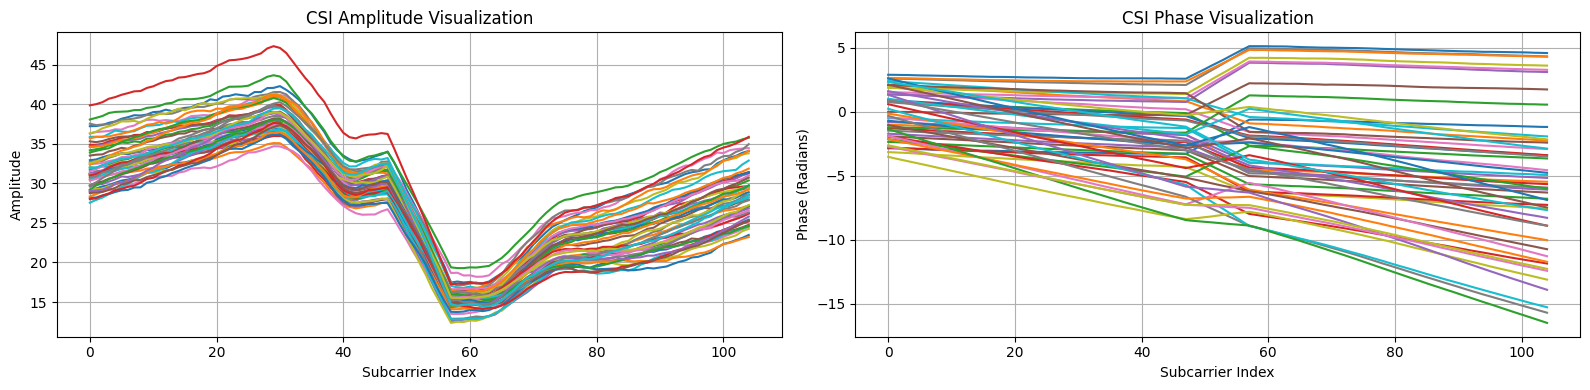

[0]


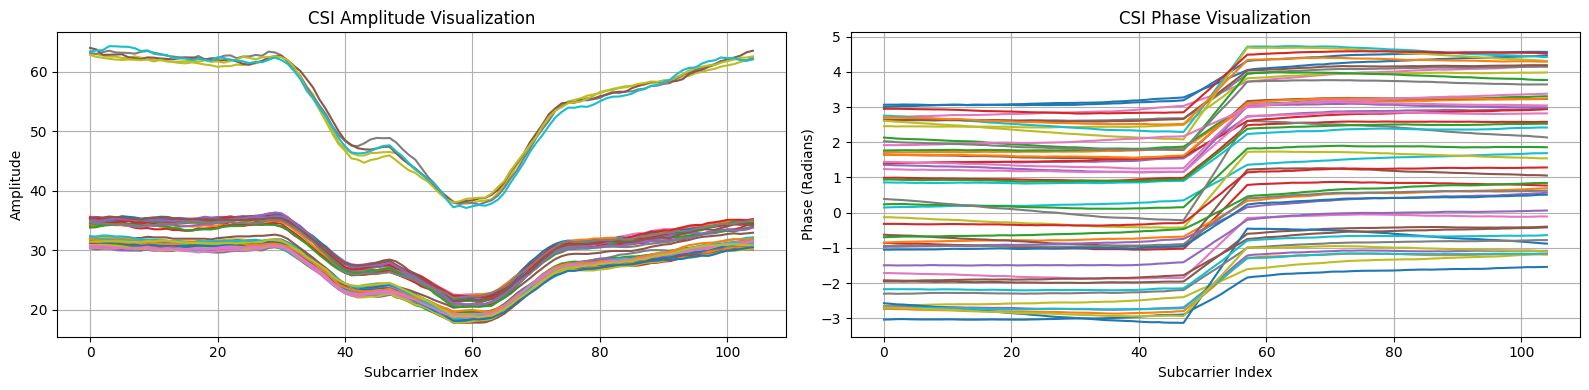

In [19]:
# File path to the CSV file
packet_count = 50
file_path = '../dataset/s2_orig/CSI_DATA_014.csv'
visualize_csi_updated(file_path)
file_path = '../dataset/s2_orig/CSI_DATA_026.csv'
visualize_csi_updated(file_path)
# visualize_3d_with_ap_device(file_path)
# visualize_csi_advanced(file_path)

In [8]:
# from scipy.signal import butter, filtfilt
# import pywt

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data, axis=0)
#     return y

[1]


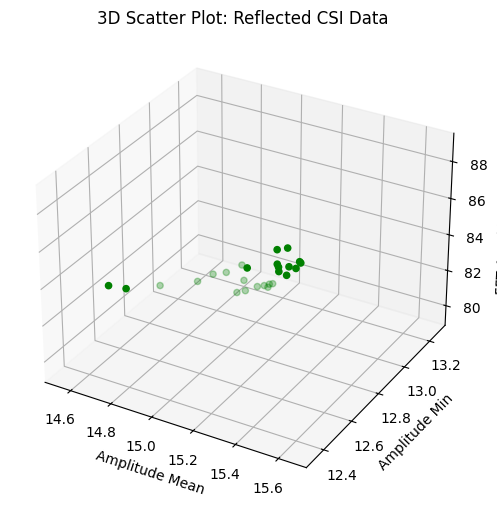

[0]


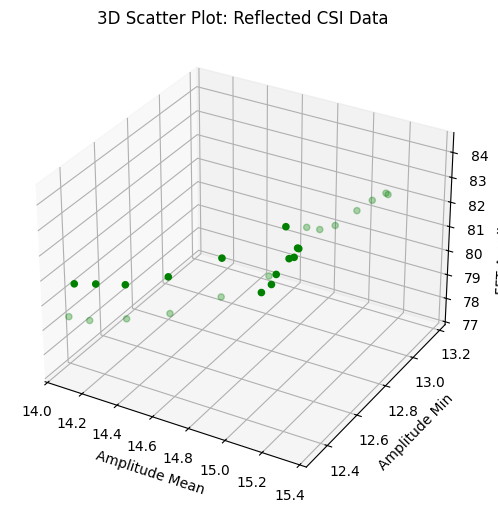

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.fftpack import fft
import math

drop_columns = [
    'Transmit_Timestamp', 'MCS', 'CWB', 'Smoothing', 'Not_Sounding', 'Noise_Floor',
    'Channel', 'Secondary_Channel', 'Received_Timestamp', 'Antenna', 'Signal_Length',
    'RX_State', 'Data_Length', 'Time_of_Flight'
]

window_size = 40
subcarrier_count = 13
columns = [f'Amean{i + 1}' for i in range(subcarrier_count)]
columns.extend([f'Amin{i + 1}' for i in range(subcarrier_count)])
columns.extend([f'Afft_Mean{i + 1}' for i in range(subcarrier_count)])


def compute_csi_amplitude_phase(raw_csi):
    amplitudes = []
    phases = []
    
    # Ensure the data length is even (pairs of I and Q)
    if len(raw_csi) % 2 != 0:
        raise ValueError('CSI data length must be even (pairs of I and Q values).')
    
    for i in range(0, len(raw_csi), 2):
        I = raw_csi[i]
        Q = raw_csi[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    return amplitudes, phases

def clean_and_filter_data(amplitudes, phases, amp_lower_threshold, amp_upper_threshold, 
                          phase_lower_threshold, phase_upper_threshold):
    cleaned_amplitudes = []
    cleaned_phases = []
    subcarriers = range(len(amplitudes))

    for i, amp, phase in zip(subcarriers, amplitudes, phases):
        # Remove null subcarriers
        if amp == 0: continue
        
        # Retain outliers based on amplitude and phase
        if ((amp < amp_lower_threshold[i]) or (amp > amp_upper_threshold[i]) and (phase < phase_lower_threshold[i]) or (phase > phase_upper_threshold[i])):
            cleaned_amplitudes.append(amp)
            cleaned_phases.append(phase)
        else:
            cleaned_amplitudes.append(np.nan)
            cleaned_phases.append(np.nan)

    return cleaned_amplitudes, cleaned_phases

def get_subcarrier_threshold(data_transposed, threshold):
    lower_threshold, upper_threshold = [], []

    for column in data_transposed:
        mean = np.mean(column)
        std_dev = np.std(column)

        lower_threshold.append(mean - threshold * std_dev)
        upper_threshold.append(mean + threshold * std_dev)

    return lower_threshold, upper_threshold

def aggregate_features(data):
    features = []
    
    features.extend(np.mean(data, axis=0))
    features.extend(np.min(data, axis=0))
    
    # FFT Features
    fft_data = np.abs(fft(data, axis=0))[:26]  # Use half-spectrum
    features.extend(np.mean(fft_data, axis=0))

    return np.array(features)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def visualize_reflections(file_path):
    csi_data = pd.read_csv(file_path)
    csi_data.drop(columns=drop_columns, inplace=True, errors='ignore')
    # Select a specific range of subcarriers to reduce file size
    csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[12:64] + eval(x)[66:118])

    # Compute the amplitude and phase of the CSI data
    csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))
    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: moving_average(x, window_size))

    ranges = [(0, 125), (125, -1)]
    features_splits = [aggregate_features(csi_data['Amplitudes'][start:end].to_list()) for start, end in ranges]
    print(csi_data['Movement'].values[:1])
    csi_data.drop(columns=['Activity', 'Movement', 'RSSI', 'Amplitudes', 'Phases', 'Raw_CSI'], inplace=True)

    rows = []

    for features_split in features_splits:
        row = np.concatenate([csi_data.loc[0], features_split])
        rows.append(row)

    X_test = pd.DataFrame(rows, columns=columns)
    
    plt.figure(figsize=(6, 8))
    ax = plt.axes(projection='3d')

    for i in range(subcarrier_count):
        x = X_test.iloc[:, i]
        y = X_test.iloc[:, i + subcarrier_count]
        z = X_test.iloc[:, i + 2 * subcarrier_count]
        ax.scatter(x, y, z, c='green', marker='o')

    plt.title("3D Scatter Plot: Reflected CSI Data")
    ax.set_xlabel("Amplitude Mean")
    ax.set_ylabel("Amplitude Min")
    ax.set_zlabel("FFT Amplitude Mean")
    plt.show()

threshold = 0
file_path = '../dataset/s2_orig/CSI_DATA_110.csv'
visualize_reflections(file_path)

file_path = '../dataset/s2_orig/CSI_DATA_090.csv'
visualize_reflections(file_path)